In [1]:
pip install pymongo openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [3]:
import pymongo
from pymongo import MongoClient
import json
import re
import os
from openai import OpenAI
from pprint import pprint
from tqdm.auto import tqdm
import random


openai_api_key  = get_secret('openai')['api_key']
client = OpenAI(api_key=openai_api_key)


mongodb_connect = get_secret('mongodb')['connection_string']


In [4]:
mongo_client = MongoClient(mongodb_connect)
db = mongo_client.demo # use or create a database named demo
tweet_collection = db.tweet_sample #use or create a collection named tweet_sample

In [5]:
filter={
    'tweet.entities.urls.images': {
        '$exists': True
    }
}
project={
    'tweet.entities.urls.images': 1, 
    'tweet.id': 1
}
result = tweet_collection.find(
  filter=filter,
  projection=project
)

In [6]:
tweet_data = []
for tweet in result:
    for url in tweet['tweet']['entities']['urls']:
        if 'images' in url:
            tweet_data.append({'tweet_id':tweet['tweet']['id'],
                               'image_url':url['images'][1]['url'] # 150*150 image 
                             })


In [7]:
print('Number of images: ',len(tweet_data))

Number of images:  32


In [8]:
from PIL import Image
from io import BytesIO
import requests

def get_image_from_url(image_url):
    response = requests.get(image_url)
    # print(response)
    if response.status_code == 200 :
        image = Image.open(BytesIO(response.content))
        return image
    else:
        return None

In [9]:
import matplotlib.pyplot as plt

def display_image(image):
    if image:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

Matplotlib is building the font cache; this may take a moment.


In [11]:
from io import BytesIO

def image_to_bytes(image_obj):
    buffered = BytesIO()
    image_obj.save(buffered, format="PNG")
    return buffered.getvalue()
vison_model = 'gpt-4o-mini'
temperature=0

def describe_image(image_url):

    response = client.chat.completions.create(
      model=vison_model,
      messages=[
        {
          "role": "user",
          "content": [
            {"type": "text", "text": """Analyze the image included in the tweet.
                                        Briefly describe the content of the image and extract entities from it.
                                        Organize the response in a JSON document:
                                        Place the description in the <img_desc> key.
                                        List the entity type and entity value in the <img_entities> key.
                                        Do not wrap the JSON code in JSON markers."""},
            {
              "type": "image_url",
              "image_url": {"url": image_url,},
 
            },
          ],
        }

      ],
    temperature=temperature
     )
    return (response.choices[0].message.content)

In [12]:
for tweet in tqdm(tweet_data):
    
    try:
        image_result =json.loads(describe_image(tweet['image_url']))
        tweet['image_desc']=image_result['img_desc']
        tweet_collection.update_one(
                {'tweet.id':tweet['tweet_id']},
                {"$set":{'tweet.img_desc':image_result['img_desc'], 
                        'tweet.img_entities':image_result['img_entities']}}
        )
    except:
        pass

  0%|          | 0/32 [00:00<?, ?it/s]

The image features two women side by side. The left woman has long brown hair and is wearing a patterned dress, while the right woman has medium-length brown hair and is dressed in a dark suit with a necklace.


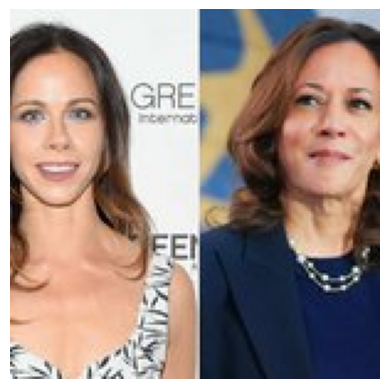

In [17]:
tweet =random.choice(tweet_data)

try:
    print(tweet['image_desc'])
    display_image(get_image_from_url(tweet['image_url']))
except:
    print("no image desc")
    pass

    

In [18]:
image_model="dall-e-2"  


def create_new_img(prompt):

    resposne = client.images.generate(
    model=image_model,
    prompt=prompt,
    n=1,
    size = "256x256"
    )
    
    
    return(resposne.data[0].url)

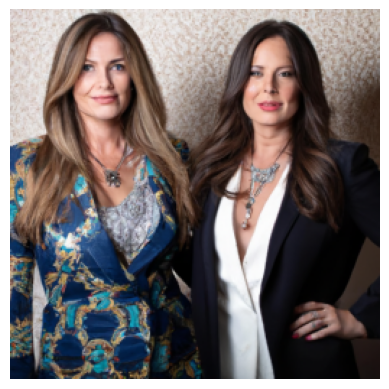

In [19]:
new_image = create_new_img(tweet['image_desc'])

display_image(get_image_from_url(new_image))

In [20]:
def create_var_img(image_url):
    img_obj = get_image_from_url(image_url)
    img_byt = image_to_bytes(img_obj)
    response = client.images.create_variation(
        image=img_byt,
        n=1,
        size="256x256",

        )
    return (response.data[0].url)   

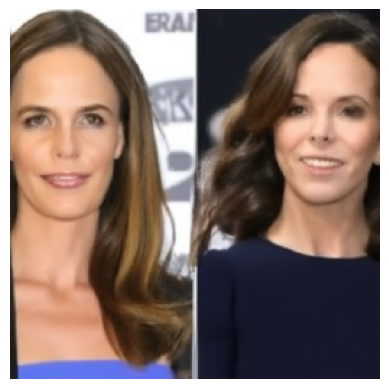

In [21]:
var_image = create_var_img(tweet['image_url'])

display_image(get_image_from_url(var_image))
                                                  

In [22]:
def create_img_edit(image, img_mask, prompt):

    response = client.images.edit(
      model="dall-e-2",
      image=image_to_bytes(image),
      mask=image_to_bytes(img_mask),
      prompt=prompt,
      n=1,
      size="256x256"
    )

    return (response.data[0].url)

In [ ]:
from torchvision import models, transforms
from PIL import Image, ImageEnhance
import torch
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load the image
image = get_image_from_url(tweet['image_url'])  # Replace with your image loading method

# Define transformations (no resizing since images are 150x150)
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Load the pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Perform segmentation
with torch.no_grad():
    output = model(input_image)['out'][0]

# Convert output to predicted classes
output_predictions = output.argmax(0).byte().numpy()


# Create a transparent RGBA mask with fully transparent non-segmented areas
height, width = output_predictions.shape
mask = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

# Define a color for segmented areas (e.g., semi-transparent red)
color = [255, 0, 0, 180]  # Red with 70% opacity
mask[output_predictions > 0] = color  # Apply color to segmented areas only

# Convert mask to a PIL Image
mask_image = Image.fromarray(mask, mode="RGBA")

# Overlay mask onto the contrast-enhanced original image
image_with_mask = Image.alpha_composite(image.convert("RGBA"), mask_image)

# Display the original image and transparent mask overlay
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title(" Image")

axs[1].imshow(image_with_mask)
axs[1].axis('off')
axs[1].set_title("Image Transparent Mask")

plt.show()

In [ ]:
img_edit = create_img_edit(image,mask_image,'in the middle of a lake with yellow ducks')

display_image(
    get_image_from_url(img_edit))